In [1]:
import os 
import pytorch_lightning as pl
import seml
import numpy as np
from tqdm import tqdm
import torch

from sacred import SETTINGS, Experiment
from functools import partial

import scanpy as sc
import scvelo as scv
import cellrank as cr
import pandas as pd

from torchdyn.core import NeuralODE

from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.base.vae import VAE, AE
from scCFM.models.cfm.cfm_module import CFMLitModule
from scCFM.models.cfm.components.simple_mlp import VelocityNet
 
from conditional_flow_matching import *

from torch.optim import AdamW

import yaml

import sys 
sys.path.insert(0, "../../../" )
from paths import EXPERIMENT_FOLDER

from conditional_flow_matching import *

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


Read anndata 

In [2]:
adata=sc.read_h5ad("/nfs/homedirs/pala/scCFM/project_dir/data/eb/eb_phate.h5ad")

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Import configurations

In [3]:
with open("/nfs/homedirs/pala/scCFM/configs/ae/eb/config.yaml", "r") as stream:
    hparams_ae = yaml.safe_load(stream)["fixed"]

In [4]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))

## Initialize and train/load autoencoder 

In [5]:
pretrained_ae = True
pretrained_ckpt_ae = "/nfs/students/pala/scCFM/experiments/ae/eb_vae/checkpoints/epoch_0033.ckpt"

In [6]:
task_name = hparams_ae["training.training"]["task_name"]
        
# Fix seed for reproducibility
torch.manual_seed(hparams_ae["training.training"]["seed"])      
if hparams_ae["training.training"]["seed"]: 
    pl.seed_everything(hparams_ae["training.training"]["seed"], workers=True)

# Initialize folder 
current_experiment_dir = EXPERIMENT_FOLDER / "ae" / task_name
current_experiment_dir.mkdir(parents=True, exist_ok=True) 
    

# Initialize datamodule
datamodule = scDataModule(**hparams_ae["datamodule.datamodule"])


# Initialize the model 
ae_model = VAE(in_dim = datamodule.dim,
            **hparams_ae["model.model"]
            ) 
        
if not pretrained_ae:
    # Initialize callbacks 
    model_ckpt_callbacks = ModelCheckpoint(dirpath=current_experiment_dir / "checkpoints", 
                                            **hparams_ae["model_checkpoint.model_checkpoint"])


    # Initialize callbacks 
    early_stopping_callbacks = EarlyStopping(**hparams_ae["early_stopping.early_stopping"])


    # Initialize logger 
    logger = WandbLogger(save_dir=current_experiment_dir / "logs", 
                         **hparams_ae["logger.logger"]) 


    # Initialize the lightning trainer 
    trainer = Trainer(default_root_dir=current_experiment_dir,
                      callbacks=[model_ckpt_callbacks, early_stopping_callbacks], 
                      logger=logger, 
                      **hparams_ae["trainer.trainer"])


    # # Fit the model 
    trainer.fit(model=ae_model, 
                      train_dataloaders=datamodule.train_dataloader(),
                      val_dataloaders=datamodule.val_dataloader())
    train_metrics = trainer.callback_metrics

else:
    ae_model.load_state_dict(torch.load(pretrained_ckpt_ae)["state_dict"])

[rank: 0] Global seed set to 42
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


**Analyze autoencoder latent space**

In [7]:
# z_cells = []
# annot = []
# with torch.no_grad():
#     for batch in datamodule.train_dataloader():
#         annot.append(batch["cond"])
#         mu = ae_model.encode(torch.log(1 + batch["X"]))["z"]
#         z_cells.append(mu)

# z_cells= torch.cat(z_cells, dim=0)
# annot = pd.DataFrame(torch.cat(annot).numpy())
# annot.columns = ["experimental_time"]

# adata_latent = sc.AnnData(X=z_cells.cpu().numpy(), 
#                   obs=annot)

In [8]:
z_cells = []
annot = []
ae_model.eval()
with torch.no_grad():
    for cell, cond in zip(adata.X.A, adata.obs.experimental_time):
        annot.append(cond)
        X = torch.from_numpy(cell).unsqueeze(0).float()
        mu = ae_model.encode(torch.log(1 + X))["z"]
        z_cells.append(mu)

z_cells= torch.cat(z_cells, dim=0)
annot = pd.DataFrame(annot)
annot.columns = ["experimental_time"]

adata_latent = sc.AnnData(X=z_cells.cpu().numpy(), 
                  obs=annot)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
sc.tl.pca(adata_latent)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)

## Perform CFM training like in the notebook

In [10]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)

First we standardize the coordinates

In [11]:
times = sorted(adata_latent.obs["experimental_time"].unique())
n_times = len(times)
# Standardize coordinates
coords = adata_latent.X
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
# adata_latent.layers["X_standardized"] = coords
adata_latent.layers["X_standardized"] = adata_latent.X.copy()
X = [
    adata_latent.layers["X_standardized"][adata_latent.obs["experimental_time"] == t]
    for t in times
]

In [12]:
# ae_model = ae_model.cuda()
# times = sorted(adata.obs["experimental_time"].unique())
# n_times = len(times)
# X = [
#     adata.X.A[adata.obs["experimental_time"] == t]
#     for t in times
# ]

In [13]:
# Shape of the time batches
[i.shape for i in X]

[(2381, 64), (4165, 64), (3278, 64), (3665, 64), (3332, 64)]

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
sigma = 0.1
dim = 64
model = MLP(dim=dim, time_varying=True, w=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

Batch collecting function

In [15]:
def get_batch(FM, X, batch_size, n_times, return_noise=False):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    xts = []
    uts = []
    noises = []
    for t_start in range(n_times - 1):
        x0 = (
            torch.from_numpy(X[t_start][np.random.randint(X[t_start].shape[0], size=batch_size)])
            .float()
            .to(device)
        )
        x1 = (
            torch.from_numpy(
                X[t_start + 1][np.random.randint(X[t_start + 1].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )
        
        if return_noise:
            t, xt, ut, eps = FM.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            noises.append(eps)
        else:
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises
    return t, xt, ut

Train OT cfm

In [16]:
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    t, xt, ut = get_batch(FM, X, batch_size, n_times)
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    if i % 20 == 0:
        print(loss.item())
    optimizer.step()

  0%|          | 3/10000 [00:00<24:13,  6.88it/s]  

0.43764546513557434


  0%|          | 23/10000 [00:01<08:32, 19.47it/s]

0.42466145753860474


  0%|          | 44/10000 [00:02<08:07, 20.41it/s]

0.4235547184944153


  1%|          | 65/10000 [00:03<08:06, 20.43it/s]

0.41724973917007446


  1%|          | 83/10000 [00:04<08:04, 20.46it/s]

0.40730005502700806


  1%|          | 104/10000 [00:05<08:02, 20.50it/s]

0.4137421250343323


  1%|▏         | 125/10000 [00:06<08:00, 20.57it/s]

0.39687925577163696


  1%|▏         | 143/10000 [00:07<07:59, 20.57it/s]

0.3941892981529236


  2%|▏         | 164/10000 [00:08<08:00, 20.45it/s]

0.3988668918609619


  2%|▏         | 185/10000 [00:09<08:02, 20.35it/s]

0.398323118686676


  2%|▏         | 203/10000 [00:10<07:56, 20.55it/s]

0.39566704630851746


  2%|▏         | 224/10000 [00:11<07:57, 20.46it/s]

0.39598435163497925


  2%|▏         | 245/10000 [00:12<07:54, 20.54it/s]

0.39567869901657104


  3%|▎         | 263/10000 [00:13<07:53, 20.55it/s]

0.395911306142807


  3%|▎         | 284/10000 [00:14<07:56, 20.39it/s]

0.39706411957740784


  3%|▎         | 305/10000 [00:15<08:09, 19.80it/s]

0.39074939489364624


  3%|▎         | 323/10000 [00:16<07:53, 20.42it/s]

0.3895755708217621


  3%|▎         | 344/10000 [00:17<07:48, 20.60it/s]

0.38044992089271545


  4%|▎         | 365/10000 [00:18<07:49, 20.53it/s]

0.39167606830596924


  4%|▍         | 383/10000 [00:19<07:49, 20.50it/s]

0.3992941379547119


  4%|▍         | 404/10000 [00:20<07:45, 20.62it/s]

0.3890805244445801


  4%|▍         | 425/10000 [00:21<07:45, 20.59it/s]

0.38709092140197754


  4%|▍         | 443/10000 [00:21<07:43, 20.61it/s]

0.3859765827655792


  5%|▍         | 464/10000 [00:23<07:45, 20.48it/s]

0.3945057988166809


  5%|▍         | 485/10000 [00:24<07:42, 20.59it/s]

0.39478158950805664


  5%|▌         | 503/10000 [00:24<07:42, 20.54it/s]

0.3839006721973419


  5%|▌         | 524/10000 [00:25<07:41, 20.54it/s]

0.3768453001976013


  5%|▌         | 545/10000 [00:26<07:41, 20.51it/s]

0.38047683238983154


  6%|▌         | 563/10000 [00:27<07:38, 20.60it/s]

0.3844159245491028


  6%|▌         | 584/10000 [00:28<07:36, 20.64it/s]

0.38580670952796936


  6%|▌         | 605/10000 [00:29<07:39, 20.43it/s]

0.3827027678489685


  6%|▌         | 623/10000 [00:30<07:34, 20.61it/s]

0.3828797936439514


  6%|▋         | 644/10000 [00:31<07:37, 20.43it/s]

0.3783554434776306


  7%|▋         | 665/10000 [00:32<07:35, 20.48it/s]

0.38063502311706543


  7%|▋         | 683/10000 [00:33<07:31, 20.65it/s]

0.38614025712013245


  7%|▋         | 704/10000 [00:34<07:32, 20.56it/s]

0.3830175995826721


  7%|▋         | 725/10000 [00:35<07:31, 20.56it/s]

0.3788038492202759


  7%|▋         | 743/10000 [00:36<07:31, 20.49it/s]

0.3844163119792938


  8%|▊         | 764/10000 [00:37<07:28, 20.61it/s]

0.3852781355381012


  8%|▊         | 785/10000 [00:38<07:26, 20.63it/s]

0.3720523416996002


  8%|▊         | 803/10000 [00:39<07:27, 20.53it/s]

0.3872409164905548


  8%|▊         | 824/10000 [00:40<07:27, 20.50it/s]

0.3870302438735962


  8%|▊         | 845/10000 [00:41<07:25, 20.55it/s]

0.37738972902297974


  9%|▊         | 863/10000 [00:42<07:26, 20.44it/s]

0.3813559412956238


  9%|▉         | 884/10000 [00:43<07:22, 20.62it/s]

0.37873995304107666


  9%|▉         | 905/10000 [00:44<07:21, 20.62it/s]

0.3814733624458313


  9%|▉         | 923/10000 [00:45<07:20, 20.61it/s]

0.3765244483947754


  9%|▉         | 944/10000 [00:46<07:18, 20.66it/s]

0.3790728449821472


 10%|▉         | 962/10000 [00:47<07:19, 20.55it/s]

0.3800617754459381


 10%|▉         | 985/10000 [00:48<07:22, 20.37it/s]

0.3791174292564392


 10%|█         | 1003/10000 [00:49<07:18, 20.52it/s]

0.38269340991973877


 10%|█         | 1024/10000 [00:50<07:15, 20.62it/s]

0.38138461112976074


 10%|█         | 1045/10000 [00:51<07:15, 20.55it/s]

0.38266754150390625


 11%|█         | 1063/10000 [00:52<07:15, 20.53it/s]

0.37862706184387207


 11%|█         | 1084/10000 [00:53<07:15, 20.48it/s]

0.3861449360847473


 11%|█         | 1105/10000 [00:54<07:12, 20.56it/s]

0.3832753598690033


 11%|█         | 1123/10000 [00:55<07:11, 20.55it/s]

0.37426817417144775


 11%|█▏        | 1144/10000 [00:56<07:12, 20.45it/s]

0.3825560212135315


 12%|█▏        | 1165/10000 [00:57<07:08, 20.63it/s]

0.3789653778076172


 12%|█▏        | 1183/10000 [00:58<07:11, 20.41it/s]

0.37888187170028687


 12%|█▏        | 1204/10000 [00:59<07:07, 20.58it/s]

0.3845725655555725


 12%|█▏        | 1225/10000 [01:00<07:07, 20.52it/s]

0.37736982107162476


 12%|█▏        | 1243/10000 [01:00<07:05, 20.57it/s]

0.3779304623603821


 13%|█▎        | 1264/10000 [01:01<07:04, 20.57it/s]

0.3800373077392578


 13%|█▎        | 1282/10000 [01:02<07:08, 20.37it/s]

0.37314629554748535


 13%|█▎        | 1303/10000 [01:03<07:04, 20.48it/s]

0.3826558291912079


 13%|█▎        | 1324/10000 [01:04<07:00, 20.61it/s]

0.38261428475379944


 13%|█▎        | 1345/10000 [01:05<07:00, 20.60it/s]

0.3781513571739197


 14%|█▎        | 1363/10000 [01:06<06:59, 20.58it/s]

0.37825343012809753


 14%|█▍        | 1384/10000 [01:07<06:57, 20.66it/s]

0.38612133264541626


 14%|█▍        | 1405/10000 [01:08<06:59, 20.50it/s]

0.3706563115119934


 14%|█▍        | 1423/10000 [01:09<06:59, 20.47it/s]

0.38101673126220703


 14%|█▍        | 1444/10000 [01:10<06:56, 20.56it/s]

0.3761766850948334


 15%|█▍        | 1465/10000 [01:11<06:53, 20.62it/s]

0.37575358152389526


 15%|█▍        | 1483/10000 [01:12<06:53, 20.59it/s]

0.37549394369125366


 15%|█▌        | 1504/10000 [01:13<06:53, 20.55it/s]

0.3820280432701111


 15%|█▌        | 1525/10000 [01:14<06:54, 20.44it/s]

0.3900536894798279


 15%|█▌        | 1543/10000 [01:15<06:52, 20.49it/s]

0.3843217194080353


 16%|█▌        | 1564/10000 [01:16<06:49, 20.59it/s]

0.37353384494781494


 16%|█▌        | 1585/10000 [01:17<06:46, 20.69it/s]

0.37913626432418823


 16%|█▌        | 1603/10000 [01:18<06:48, 20.54it/s]

0.3707959055900574


 16%|█▌        | 1624/10000 [01:19<06:47, 20.57it/s]

0.37580662965774536


 16%|█▋        | 1645/10000 [01:20<06:46, 20.57it/s]

0.37749630212783813


 17%|█▋        | 1663/10000 [01:21<06:45, 20.56it/s]

0.3791190981864929


 17%|█▋        | 1684/10000 [01:22<06:43, 20.63it/s]

0.3753325343132019


 17%|█▋        | 1705/10000 [01:23<06:42, 20.62it/s]

0.3795351982116699


 17%|█▋        | 1723/10000 [01:24<06:44, 20.48it/s]

0.3714613914489746


 17%|█▋        | 1744/10000 [01:25<06:40, 20.63it/s]

0.37281399965286255


 18%|█▊        | 1765/10000 [01:26<06:40, 20.56it/s]

0.3722253441810608


 18%|█▊        | 1783/10000 [01:27<06:39, 20.57it/s]

0.3709825575351715


 18%|█▊        | 1804/10000 [01:28<06:38, 20.57it/s]

0.3718273639678955


 18%|█▊        | 1825/10000 [01:29<06:36, 20.60it/s]

0.3691760301589966


 18%|█▊        | 1843/10000 [01:30<06:34, 20.67it/s]

0.37350034713745117


 19%|█▊        | 1864/10000 [01:31<06:35, 20.55it/s]

0.3709668815135956


 19%|█▉        | 1885/10000 [01:32<06:32, 20.68it/s]

0.3697822690010071


 19%|█▉        | 1903/10000 [01:33<06:33, 20.57it/s]

0.3725403845310211


 19%|█▉        | 1924/10000 [01:34<06:34, 20.49it/s]

0.37473779916763306


 19%|█▉        | 1945/10000 [01:35<06:33, 20.47it/s]

0.3730010688304901


 20%|█▉        | 1963/10000 [01:35<06:31, 20.54it/s]

0.38001593947410583


 20%|█▉        | 1984/10000 [01:36<06:27, 20.66it/s]

0.3748880624771118


 20%|██        | 2005/10000 [01:37<06:30, 20.50it/s]

0.3806973099708557


 20%|██        | 2023/10000 [01:38<06:27, 20.59it/s]

0.37525132298469543


 20%|██        | 2044/10000 [01:39<06:27, 20.55it/s]

0.37772005796432495


 21%|██        | 2065/10000 [01:40<06:23, 20.69it/s]

0.3821865916252136


 21%|██        | 2083/10000 [01:41<06:24, 20.59it/s]

0.37411195039749146


 21%|██        | 2104/10000 [01:42<06:24, 20.54it/s]

0.3752831220626831


 21%|██▏       | 2125/10000 [01:43<06:22, 20.61it/s]

0.370845764875412


 21%|██▏       | 2143/10000 [01:44<06:22, 20.56it/s]

0.372103214263916


 22%|██▏       | 2164/10000 [01:45<06:20, 20.60it/s]

0.3754139542579651


 22%|██▏       | 2185/10000 [01:46<06:19, 20.59it/s]

0.36853671073913574


 22%|██▏       | 2203/10000 [01:47<06:18, 20.58it/s]

0.37518131732940674


 22%|██▏       | 2224/10000 [01:48<06:16, 20.65it/s]

0.3774096965789795


 22%|██▏       | 2236/10000 [01:49<06:19, 20.47it/s]

KeyboardInterrupt



**Check the streamplots**

In [17]:
def add_velocity_to_adata(adata, model):
    # Put model in evaluation mode
    model.eval()
    velocities = []
    with torch.no_grad():
        for i, x in enumerate(adata.X):
            t = torch.tensor(adata.obs.experimental_time[i]).view(1, -1).float().cuda()
            x = torch.from_numpy(x).view(1, -1).float().cuda()
            dx_dt = model(torch.cat([x, t], dim=1))
            velocities.append(dx_dt.cpu().numpy())
    velocities = np.concatenate(velocities, axis=0)

    adata.layers["velocity"] = velocities

In [18]:
add_velocity_to_adata(adata_latent, model)

In [19]:
adata_latent.layers["X_latent"] = adata_latent.X.copy()

In [20]:
vk = cr.kernels.VelocityKernel(adata_latent,
                          xkey="X_latent", 
                        vkey="velocity").compute_transition_matrix()

vk.compute_projection(basis="umap")

  0%|          | 0/16821 [00:00<?, ?cell/s]

  0%|          | 0/16821 [00:00<?, ?cell/s]

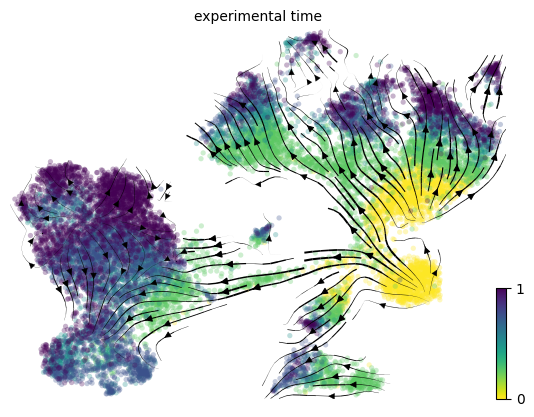

In [21]:
scv.pl.velocity_embedding_stream(adata_latent, vkey="T_fwd", basis="umap", color="experimental_time")

**Propagate with neural ODE**

In [22]:
node = NeuralODE(
    torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)

# Append first time point
trajs = []
with torch.no_grad():
    X_pf = torch.from_numpy(X[0])
    trajs.append(X_pf.unsqueeze(0))
    for t in range(n_times-1):
        traj = node.trajectory(X_pf.float().to(device),
            t_span=torch.linspace(t, t+1, 400),
        ).cpu()
        X_pf = traj[-1]
        trajs.append(X_pf.unsqueeze(0))

trajs = torch.cat(trajs, dim=0)

In [23]:
X_pf.shape

torch.Size([2381, 64])

In [24]:
X_pf = trajs.view(trajs.shape[0]*trajs.shape[1], -1)
times = torch.arange(5).unsqueeze(1).expand(trajs.shape[0],trajs.shape[1]).ravel()
times = pd.DataFrame(times)
times.columns = ["experimental_time"]

In [25]:
times.shape

(11905, 1)

In [26]:
adata_pf = sc.AnnData(X=X_pf.cpu().numpy(), 
                     obs=times)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [27]:
sc.tl.pca(adata_pf)
sc.pp.neighbors(adata_pf)
sc.tl.umap(adata_pf)

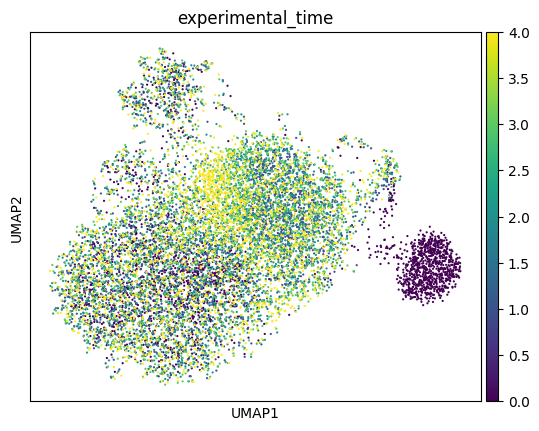

In [28]:
sc.pl.umap(adata_pf, color="experimental_time")

Co-embed

In [29]:
X_total = np.concatenate([adata_latent.X, X_pf], axis=0)
dataset_type = ["True" for _ in range(adata_latent.X.shape[0])] + \
                ["False" for _ in range(X_pf.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["Dataset_type"]

In [30]:
adata_pf = sc.AnnData(X=X_total, 
                     obs=dataset_type)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [31]:
sc.tl.pca(adata_pf)
sc.pp.neighbors(adata_pf)
sc.tl.umap(adata_pf)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


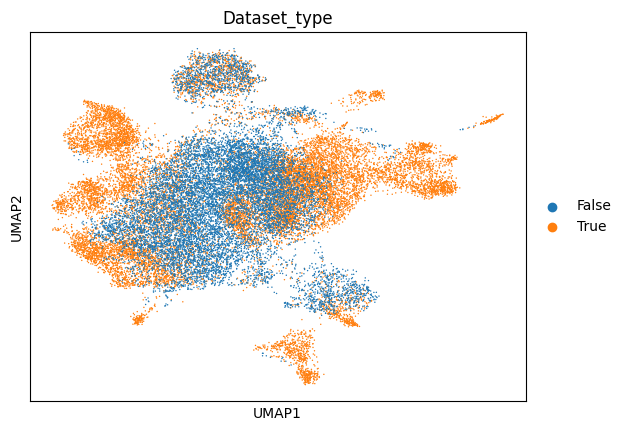

In [32]:
sc.pl.umap(adata_pf, color="Dataset_type")

In [33]:
# z_cells = []
# annot = []
# with torch.no_grad():
#     for batch in datamodule.train_dataloader():
#         annot.append(batch["cond"])
#         mu = ae_model.encode(torch.log(1 + batch["X"]))["z"]
#         z_cells.append(mu)

# z_cells= torch.cat(z_cells, dim=0)
# annot = pd.DataFrame(torch.cat(annot).numpy())
# annot.columns = ["experimental_time"]

# adata_latent = sc.AnnData(X=z_cells.cpu().numpy(), 
#                   obs=annot)